In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION']='python'

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
import json
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
from sklearn.model_selection import train_test_split
import random

# import from scfair-reproducibility
from scfair_reproducibility.benchmark_VAE.vi import VI
from scfair_reproducibility.evaluation.metrics import *

# import from scib_metrics
from scfair_reproducibility.scib_metrics_dev.src.scib_metrics.benchmark import Benchmarker

# other methods
# import cpa
# from data.biolord_dev.src import biolord


/home/jupyter/analysis/dis2p_trials/scfair_20231003/scfair_dev_20231003_env/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/jupyter/analysis/dis2p_trials/scfair_20231003/scfair_dev_20231003_env/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/jupyter/analysis/dis2p_trials/scfair_20231003/scfair_dev_20231003_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


In [3]:
from dis2p.dis2pvae import *
from dis2p.dis2pvi import *
from dis2p.ood import *
from dis2p.trainingplan import *
from dis2p.utils import *


In [4]:
# load dataset
adata = scvi.data.heart_cell_atlas_subsampled()

# preprocess dataset
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

# specify name of dataset 
data_name = 'HeartAtlas'

# specify attributes
cats = ['cell_type', 'cell_source', 'gender', 'region']

# create numerical index for each attr in cats
create_cats_idx(adata, cats)

# save adata
adata.write_h5ad('data/heart_preprocessed1200.h5ad')

today = datetime.today().strftime('%Y-%m-%d')

INFO     File data/hca_subsampled_20k.h5ad already downloaded                                                      


/home/jupyter/analysis/dis2p_trials/scfair_20231003/scfair_dev_20231003_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/jupyter/analysis/dis2p_trials/scfair_20231003/scfair_dev_20231003_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [5]:
adata = ad.read('data/heart_preprocessed1200.h5ad')

# specify name of dataset 
data_name = 'HeartAtlas'

# specify attributes
cats = ['cell_type', 'cell_source', 'gender', 'region']

# create numerical index for each attr in cats
create_cats_idx(adata, cats)

today = datetime.today().strftime('%Y-%m-%d')

In [6]:
cov_name = 'gender'
other_covs_values = ('Ventricular_Cardiomyocyte', 'Sanger-Nuclei', 'RV')
cov_value = 'Male'
cov_value_cf = 'Female'

other_cats = [c for c in cats if c != cov_name]

train_idx = []
val_idx = []
train_val_idx = []
ood_idx = []
source_ood_idx = []
target_ood_idx = []

for i in range(adata.n_obs):
    cov_value_i = adata[i].obs[cov_name][0]

    if all(adata[i].obs[c][0] == other_covs_values[k] for k, c in enumerate(other_cats)):
        ood_idx.append(i)
        if cov_value_i == cov_value_cf:
            target_ood_idx.append(i)
        elif cov_value_i == cov_value:
            source_ood_idx.append(i)
    else:
        train_val_idx.append(i)
        
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.2)

adata_train = adata[train_idx].copy()
adata_valid = adata[val_idx].copy()
adata_train_val = adata[train_idx + val_idx].copy()
adata_ood = adata[ood_idx].copy()

source_adata = adata[source_ood_idx].copy()
target_adata = adata[target_ood_idx].copy()

# add split_key
split_list = []
for i in range(adata.n_obs):
    if i in train_idx:
        split_list.append('train')
    elif i in val_idx:
        split_list.append('test')
    else:
        split_list.append('ood')
    
split_key = 'split'
adata.obs[split_key] = pd.Categorical(split_list)

/home/jupyter/analysis/dis2p_trials/scfair_20231003/scfair_dev_20231003_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/var/tmp/ipykernel_12724/448121039.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cov_value_i = adata[i].obs[cov_name][0]
/var/tmp/ipykernel_12724/448121039.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if all(adata[i].obs[c][0] == other_covs_values[k] for k, c in enumerate(other_cats)):


In [7]:
adata

AnnData object with n_obs × n_vars = 18641 × 1200
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used', 'cell_type_idx', 'cell_source_idx', 'gender_idx', 'region_idx', 'split'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'hvg', 'log1p'
    layers: 'counts'

In [7]:
true_x_count = torch.tensor(adata.layers["counts"][target_ood_idx].toarray())
true_x_counts_mean = torch.mean(true_x_count, dim=0)

true_x_counts_variance = torch.sub(true_x_count, true_x_counts_mean)
true_x_counts_variance = torch.pow(true_x_counts_variance, 2)
true_x_counts_variance = torch.mean(true_x_counts_variance, dim=0)

true_x_counts_mean, true_x_counts_variance = true_x_counts_mean.to('cpu'), true_x_counts_variance.to('cpu')

# dis2p

In [8]:
from dis2p.dis2pvi import Dis2pVI
from dis2p.ood import *

# CPA (improve)

In [9]:
perturbation_key = cov_name
control_group = cov_value

adata_cpa = adata.copy()
adata_cpa.X = adata.layers['counts']

cpa.CPA.setup_anndata(adata_cpa,
                    perturbation_key=perturbation_key,
                    control_group=control_group,
                    categorical_covariate_keys=[c for c in cats if c != cov_name],
                    )

100%|██████████| 18641/18641 [00:00<00:00, 1136259.57it/s]


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [73]:
module_name = 'CPA'

model = cpa.CPA(adata=adata_cpa, 
                split_key=split_key, 
                recon_loss='zinb', 
                doser_type='linear',
                n_layers_encoder=1,
                n_layers_decoder=1,
                dropout_rate_decoder=0.2,
                dropout_rate_encoder=0.1,
                n_latent=10,)

save_path = f'models/{module_name}/{data_name},{today},10_30_PM/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
plan_kwargs = {'dropout_rate_adv': 0.3, 'adv_steps': 2}

model.train(max_epochs=1000,
            use_gpu=True,
            batch_size=1024,
            plan_kwargs=plan_kwargs,
            early_stopping_patience=10,
            check_val_every_n_epoch=10,
            save_path=save_path,
           )

Global seed set to 0

100%|██████████| 2/2 [00:00<00:00, 44.24it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8391e223-da74-0458-e121-783edc78bf21/0/0]


Epoch 10/1000:   1%|          | 9/1000 [00:38<1:09:27,  4.21s/it, v_num=1, recon=326, r2_mean=0.344, adv_loss=5.89, acc_pert=0.577, acc_cell_type=0.529, acc_cell_source=0.537, acc_gender=0.572, acc_region=0.219]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 2.496627859568155
disnt_after = 3.6692862435301596
val_r2_mean = 0.32186472386463355
val_r2_var = 0.0733192572486312
Epoch 20/1000:   2%|▏         | 19/1000 [01:21<1:08:13,  4.17s/it, v_num=1, recon=305, r2_mean=0.47, adv_loss=4.88, acc_pert=0.598, acc_cell_type=0.771, acc_cell_source=0.609, acc_gender=0.585, acc_region=0.258, val_recon=329, disnt_basal=2.5, disnt_after=3.67, val_r2_mean=0.322, val_KL=nan] 
disnt_basal = 2.5454246488975527
disnt_after = 3.5913274241722286
val_r2_mean = 0.4606754502733993
val_r2_var = 0.10471718281483648
Epoch 30/1000:   3%|▎         | 29/1000 [02:04<1:08:34,  4.24s/it, v_num=1, recon=297, r2_mean=0.519, adv_loss=4.39, acc_pert=0.617, acc_cell_type=0.822, acc_cell_source=0.663, acc_gender=0.607, acc_region=0.286, val_recon=309, disnt_basal=2.55, disnt_after=3.59, val_r2_mean=0.461, val_KL=nan]
disnt_basal = 2.5618639891165618
disnt_after = 3.4853004998567663
val_r2_mean = 0.5133225529705658
val_r2_var = 0.1293189911784183
Epoch 40/1000:  

In [11]:
module_name = 'CPA'
perturbation_key = cov_name
control_group = cov_value

model = cpa.CPA.load(dir_path=f'models/{module_name}/{data_name},2023-09-28,10_30_PM',
                     adata=adata_cpa, use_gpu=True)

INFO     File models/CPA/HeartAtlas,2023-09-28,10_30_PM/model.pt already downloaded                                


100%|██████████| 18641/18641 [00:00<00:00, 1140386.24it/s]
Global seed set to 0


In [13]:
cpa.CPA.setup_anndata(source_adata,
                    perturbation_key=perturbation_key,
                    control_group=control_group,
                    categorical_covariate_keys=[c for c in cats if c != cov_name],
                    )

100%|██████████| 284/284 [00:00<00:00, 953708.84it/s]

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [14]:
model.predict(source_adata)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


100%|██████████| 9/9 [00:01<00:00,  7.93it/s]


In [15]:
x_pred_cpa = torch.tensor(source_adata.obsm['CPA_pred'])

px_cf_mean_pred_cpa = torch.mean(x_pred_cpa, axis=0)

px_cf_variance_cpa = torch.sub(x_pred_cpa, px_cf_mean_pred_cpa)
px_cf_variance_cpa = torch.pow(px_cf_variance_cpa, 2)
px_cf_variance_pred_cpa = torch.mean(px_cf_variance_cpa, axis=0)

In [16]:
r2, r2_log, r2_deg, r2_log_deg = r2_eval(adata, cov_name, cov_value_cf, true_x_counts_mean, px_cf_mean_pred_cpa, n_top_deg=20)

All Genes
R2 = 0.1656
R2 log = 0.5088
DE Genes (n_top=20)
R2 = -0.2569
R2 log = -0.2738


In [17]:
r2, r2_log, r2_deg, r2_log_deg = r2_eval(adata, cov_name, cov_value_cf, true_x_counts_mean, px_cf_mean_pred_cpa, n_top_deg=100)

All Genes
R2 = 0.1656
R2 log = 0.5088
DE Genes (n_top=100)
R2 = 0.0666
R2 log = 0.3579


In [18]:
r2_v, r2_v_log, r2_v_deg, r2_v_log_deg = r2_eval(adata, cov_name, cov_value_cf, true_x_counts_variance, px_cf_variance_pred_cpa, n_top_deg=20)

All Genes
R2 = -0.0042
R2 log = -0.0255
DE Genes (n_top=20)
R2 = -0.2671
R2 log = -1.2496


# CPA trials

In [66]:
module_name = 'CPA'

model = cpa.CPA(adata=adata_cpa, 
                split_key=split_key, 
                recon_loss='zinb', 
                doser_type='linear',
                n_layers_encoder=1,
                n_layers_decoder=1,
                n_latent=10,)

save_path = f'models/{module_name}/{data_name},{today},10_PM/'
if not os.path.exists(save_path):
    os.makedirs(save_path)


model.train(max_epochs=1000,
            use_gpu=True,
            early_stopping_patience=10,
            check_val_every_n_epoch=10,
            save_path=save_path,
           )

Global seed set to 0

100%|██████████| 2/2 [00:00<00:00, 45.24it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8391e223-da74-0458-e121-783edc78bf21/0/0]


Epoch 10/1000:   1%|          | 9/1000 [02:04<3:48:42, 13.85s/it, v_num=1, recon=298, r2_mean=0.408, adv_loss=3.62, acc_pert=0.64, acc_cell_type=0.913, acc_cell_source=0.735, acc_gender=0.643, acc_region=0.336]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 1.9376250543320557
disnt_after = 2.2342007689196888
val_r2_mean = 0.4177842290193109
val_r2_var = 0.04287997062059961
Epoch 12/1000:   1%|          | 11/1000 [02:35<3:57:33, 14.41s/it, v_num=1, recon=295, r2_mean=0.423, adv_loss=3.6, acc_pert=0.649, acc_cell_type=0.908, acc_cell_source=0.742, acc_gender=0.649, acc_region=0.34, val_recon=298, disnt_basal=1.94, disnt_after=2.23, val_r2_mean=0.418, val_KL=nan]  

In [64]:
module_name = 'CPA'

model = cpa.CPA(adata=adata_cpa, 
                split_key=split_key, 
                recon_loss='zinb', 
                doser_type='linear',
                n_latent=10,)

save_path = f'models/{module_name}/{data_name},{today},9_30_PM/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

model.train(max_epochs=1000,
            use_gpu=True,
            early_stopping_patience=10,
            check_val_every_n_epoch=10,
            save_path=save_path,
           )

Global seed set to 0

100%|██████████| 2/2 [00:00<00:00, 44.71it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8391e223-da74-0458-e121-783edc78bf21/0/0]


Epoch 10/1000:   1%|          | 9/1000 [02:03<3:44:23, 13.59s/it, v_num=1, recon=296, r2_mean=0.426, adv_loss=4.21, acc_pert=0.62, acc_cell_type=0.778, acc_cell_source=0.665, acc_gender=0.627, acc_region=0.292] 


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 1.8181130714156584
disnt_after = 2.4165320881128007
val_r2_mean = 0.4429301515749927
val_r2_var = 0.05061732285615547
Epoch 20/1000:   2%|▏         | 19/1000 [04:25<3:48:14, 13.96s/it, v_num=1, recon=286, r2_mean=0.469, adv_loss=4.28, acc_pert=0.614, acc_cell_type=0.691, acc_cell_source=0.686, acc_gender=0.626, acc_region=0.313, val_recon=294, disnt_basal=1.82, disnt_after=2.42, val_r2_mean=0.443, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 1.7837473106997292
disnt_after = 2.373054578522874
val_r2_mean = 0.4748545269224843
val_r2_var = 0.07307010394764515
Epoch 30/1000:   3%|▎         | 29/1000 [06:47<3:46:31, 14.00s/it, v_num=1, recon=281, r2_mean=0.489, adv_loss=4.31, acc_pert=0.618, acc_cell_type=0.665, acc_cell_source=0.686, acc_gender=0.63, acc_region=0.32, val_recon=288, disnt_basal=1.78, disnt_after=2.37, val_r2_mean=0.475, val_KL=nan]  
disnt_basal = 1.780428189137132
disnt_after = 2.3384216055149243
val_r2_mean = 0.4841563055216537
val_r2_var = 0.07686952148328223
Epoch 40/1000:   4%|▍         | 39/1000 [09:08<3:39:48, 13.72s/it, v_num=1, recon=277, r2_mean=0.502, adv_loss=4.32, acc_pert=0.621, acc_cell_type=0.656, acc_cell_source=0.687, acc_gender=0.633, acc_region=0.324, val_recon=289, disnt_basal=1.78, disnt_after=2.34, val_r2_mean=0.484, val_KL=nan]
disnt_basal = 1.7513930998521112
disnt_after = 2.2920358464117414
val_r2_mean = 0.49280333403099247
val_r2_var = 0.08394934974940392
Epoch 50/1000:

In [61]:
module_name = 'CPA'

model = cpa.CPA(adata=adata_cpa, 
                split_key=split_key, 
                recon_loss='zinb', 
                doser_type='linear',
                n_latent=32,)

save_path = f'models/{module_name}/{data_name},{today}_9PM/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

model.train(max_epochs=1000,
            use_gpu=True,
            early_stopping_patience=10,
            check_val_every_n_epoch=10,
            save_path=save_path,
           )

Global seed set to 0

100%|██████████| 2/2 [00:00<00:00, 47.40it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8391e223-da74-0458-e121-783edc78bf21/0/0]


Epoch 10/1000:   1%|          | 9/1000 [02:04<3:47:39, 13.78s/it, v_num=1, recon=295, r2_mean=0.434, adv_loss=5.15, acc_pert=0.601, acc_cell_type=0.553, acc_cell_source=0.575, acc_gender=0.605, acc_region=0.268]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 1.6642462637124464
disnt_after = 2.781179969886695
val_r2_mean = 0.4458982518373444
val_r2_var = 0.05129972067011736
Epoch 20/1000:   2%|▏         | 19/1000 [04:26<3:46:36, 13.86s/it, v_num=1, recon=284, r2_mean=0.484, adv_loss=5.62, acc_pert=0.576, acc_cell_type=0.424, acc_cell_source=0.483, acc_gender=0.598, acc_region=0.27, val_recon=293, disnt_basal=1.66, disnt_after=2.78, val_r2_mean=0.446, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 1.6123794622280796
disnt_after = 2.803832422119705
val_r2_mean = 0.48206312611886876
val_r2_var = 0.07424441067661555
Epoch 30/1000:   3%|▎         | 29/1000 [06:47<3:42:13, 13.73s/it, v_num=1, recon=276, r2_mean=0.515, adv_loss=5.68, acc_pert=0.581, acc_cell_type=0.398, acc_cell_source=0.475, acc_gender=0.601, acc_region=0.283, val_recon=287, disnt_basal=1.61, disnt_after=2.8, val_r2_mean=0.482, val_KL=nan]


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 1.5508954684385323
disnt_after = 2.8083898679844963
val_r2_mean = 0.5073564323678269
val_r2_var = 0.09252901204196243
Epoch 40/1000:   4%|▍         | 39/1000 [09:08<3:41:30, 13.83s/it, v_num=1, recon=271, r2_mean=0.538, adv_loss=5.73, acc_pert=0.562, acc_cell_type=0.371, acc_cell_source=0.481, acc_gender=0.585, acc_region=0.294, val_recon=282, disnt_basal=1.55, disnt_after=2.81, val_r2_mean=0.507, val_KL=nan]


Epoch 00039: cpa_metric reached. Module best state updated.



disnt_basal = 1.54243935365779
disnt_after = 2.808637876822378
val_r2_mean = 0.5161983489473385
val_r2_var = 0.09725826027754916
Epoch 50/1000:   5%|▍         | 49/1000 [11:29<3:37:40, 13.73s/it, v_num=1, recon=266, r2_mean=0.553, adv_loss=5.74, acc_pert=0.577, acc_cell_type=0.371, acc_cell_source=0.479, acc_gender=0.598, acc_region=0.291, val_recon=279, disnt_basal=1.54, disnt_after=2.81, val_r2_mean=0.516, val_KL=nan]


Epoch 00049: cpa_metric reached. Module best state updated.



disnt_basal = 1.5433695260452367
disnt_after = 2.8067220535381456
val_r2_mean = 0.5289095082837253
val_r2_var = 0.10649365998832126
Epoch 60/1000:   6%|▌         | 59/1000 [13:51<3:38:19, 13.92s/it, v_num=1, recon=263, r2_mean=0.564, adv_loss=5.75, acc_pert=0.577, acc_cell_type=0.374, acc_cell_source=0.48, acc_gender=0.594, acc_region=0.29, val_recon=278, disnt_basal=1.54, disnt_after=2.81, val_r2_mean=0.529, val_KL=nan]  


Epoch 00059: cpa_metric reached. Module best state updated.



disnt_basal = 1.5327087524177019
disnt_after = 2.8062701028936314
val_r2_mean = 0.5380697497930915
val_r2_var = 0.1131704020757672
Epoch 70/1000:   7%|▋         | 69/1000 [16:12<3:33:11, 13.74s/it, v_num=1, recon=259, r2_mean=0.575, adv_loss=5.72, acc_pert=0.575, acc_cell_type=0.385, acc_cell_source=0.484, acc_gender=0.596, acc_region=0.292, val_recon=276, disnt_basal=1.53, disnt_after=2.81, val_r2_mean=0.538, val_KL=nan]
disnt_basal = 1.534447336992069
disnt_after = 2.795852017725113
val_r2_mean = 0.5387103183784467
val_r2_var = 0.11406228828798155
Epoch 80/1000:   8%|▊         | 79/1000 [18:32<3:30:55, 13.74s/it, v_num=1, recon=256, r2_mean=0.583, adv_loss=5.73, acc_pert=0.588, acc_cell_type=0.379, acc_cell_source=0.483, acc_gender=0.602, acc_region=0.295, val_recon=273, disnt_basal=1.53, disnt_after=2.8, val_r2_mean=0.539, val_KL=nan] 
disnt_basal = 1.5323689752197482
disnt_after = 2.790357612848756
val_r2_mean = 0.5389299615072384
val_r2_var = 0.10963549222049562
Epoch 90/1000:   

In [58]:
module_name = 'CPA'

model = cpa.CPA(adata=adata, 
                split_key=split_key, 
                recon_loss='gauss', 
                doser_type='linear',
                n_latent=64,)

save_path = f'models/{module_name}/{data_name},{today}_8PM/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

model.train(max_epochs=1000,
            use_gpu=True,
            early_stopping_patience=10,
            check_val_every_n_epoch=10,
            save_path=save_path,
           )

Global seed set to 0
100%|██████████| 2/2 [00:00<00:00, 45.36it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8391e223-da74-0458-e121-783edc78bf21/0/0]


Epoch 10/1000:   1%|          | 9/1000 [02:12<3:53:43, 14.15s/it, v_num=1, recon=-399, r2_mean=0.368, adv_loss=4.04, acc_pert=0.584, acc_cell_type=0.845, acc_cell_source=0.687, acc_gender=0.588, acc_region=0.285]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 1.9340003695692134
disnt_after = 2.588388974555734
val_r2_mean = 0.38355003023439926
val_r2_var = 0.06955434185827586
Epoch 20/1000:   2%|▏         | 19/1000 [04:35<3:49:48, 14.06s/it, v_num=1, recon=-586, r2_mean=0.374, adv_loss=4.04, acc_pert=0.595, acc_cell_type=0.832, acc_cell_source=0.675, acc_gender=0.595, acc_region=0.278, val_recon=-329, disnt_basal=1.93, disnt_after=2.59, val_r2_mean=0.384, val_KL=nan]
disnt_basal = 1.924035705147959
disnt_after = 2.52824856868873
val_r2_mean = 0.38482832209771317
val_r2_var = 0.06157102616588139
Epoch 30/1000:   3%|▎         | 29/1000 [06:59<3:47:14, 14.04s/it, v_num=1, recon=-701, r2_mean=0.372, adv_loss=4.02, acc_pert=0.596, acc_cell_type=0.824, acc_cell_source=0.697, acc_gender=0.597, acc_region=0.285, val_recon=-349, disnt_basal=1.92, disnt_after=2.53, val_r2_mean=0.385, val_KL=nan]
disnt_basal = 1.9206401656747545
disnt_after = 2.509506296637574
val_r2_mean = 0.3804689466657812
val_r2_var = 0.05940990770199061
Epoch 40/100

# CPA

In [30]:
perturbation_key = cov_name
control_group = cov_value

cpa.CPA.setup_anndata(adata,
                    perturbation_key=perturbation_key,
                    control_group=control_group,
                    categorical_covariate_keys=cats,
                    )

100%|██████████| 18641/18641 [00:00<00:00, 1278259.50it/s]


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [31]:
module_name = 'CPA'

model = cpa.CPA(adata=adata, split_key=split_key)

save_path = f'models/{module_name}/{data_name},{today}/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

model.train(max_epochs=400,
            use_gpu=True,
            early_stopping_patience=10,
            check_val_every_n_epoch=10,
            save_path=save_path,
           )

Global seed set to 0
100%|██████████| 2/2 [00:00<00:00, 42.87it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8391e223-da74-0458-e121-783edc78bf21/0/0]


Epoch 10/400:   2%|▏         | 9/400 [02:04<1:29:42, 13.77s/it, v_num=1, recon=314, r2_mean=0.405, adv_loss=5.89, acc_pert=0.568, acc_cell_type=0.391, acc_cell_source=0.476, acc_gender=0.605, acc_region=0.255]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 1.7667713550422586
disnt_after = 2.7195045240608406
val_r2_mean = 0.4092180040617501
val_r2_var = -0.004967708668350296
Epoch 20/400:   5%|▍         | 19/400 [04:26<1:27:57, 13.85s/it, v_num=1, recon=301, r2_mean=0.445, adv_loss=5.9, acc_pert=0.579, acc_cell_type=0.319, acc_cell_source=0.471, acc_gender=0.603, acc_region=0.278, val_recon=316, disnt_basal=1.77, disnt_after=2.72, val_r2_mean=0.409, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 1.5844365810046042
disnt_after = 2.7665776612127697
val_r2_mean = 0.4382088709761017
val_r2_var = 0.016291998519173047
Epoch 30/400:   7%|▋         | 29/400 [06:48<1:25:31, 13.83s/it, v_num=1, recon=291, r2_mean=0.471, adv_loss=5.78, acc_pert=0.587, acc_cell_type=0.342, acc_cell_source=0.473, acc_gender=0.613, acc_region=0.274, val_recon=306, disnt_basal=1.58, disnt_after=2.77, val_r2_mean=0.438, val_KL=nan]
disnt_basal = 1.612523884849694
disnt_after = 2.7519173548526394
val_r2_mean = 0.45586601774836194
val_r2_var = 0.027350632887494983
Epoch 40/400:  10%|▉         | 39/400 [09:15<1:23:28, 13.87s/it, v_num=1, recon=284, r2_mean=0.489, adv_loss=5.71, acc_pert=0.591, acc_cell_type=0.384, acc_cell_source=0.498, acc_gender=0.602, acc_region=0.28, val_recon=301, disnt_basal=1.61, disnt_after=2.75, val_r2_mean=0.456, val_KL=nan] 


Epoch 00039: cpa_metric reached. Module best state updated.



disnt_basal = 1.553794846855608
disnt_after = 2.7508052361080484
val_r2_mean = 0.46502875785105136
val_r2_var = 0.034082882799349505
Epoch 50/400:  12%|█▏        | 49/400 [11:36<1:21:05, 13.86s/it, v_num=1, recon=277, r2_mean=0.505, adv_loss=5.73, acc_pert=0.601, acc_cell_type=0.356, acc_cell_source=0.481, acc_gender=0.618, acc_region=0.288, val_recon=296, disnt_basal=1.55, disnt_after=2.75, val_r2_mean=0.465, val_KL=nan]


Epoch 00049: cpa_metric reached. Module best state updated.



disnt_basal = 1.5508021783454677
disnt_after = 2.7498763146801455
val_r2_mean = 0.4683244193558171
val_r2_var = 0.038992803465830415
Epoch 60/400:  15%|█▍        | 59/400 [13:58<1:18:48, 13.87s/it, v_num=1, recon=272, r2_mean=0.519, adv_loss=5.65, acc_pert=0.619, acc_cell_type=0.367, acc_cell_source=0.504, acc_gender=0.614, acc_region=0.301, val_recon=294, disnt_basal=1.55, disnt_after=2.75, val_r2_mean=0.468, val_KL=nan]


Epoch 00059: cpa_metric reached. Module best state updated.



disnt_basal = 1.5371320948216107
disnt_after = 2.7442866154252155
val_r2_mean = 0.4690925794249258
val_r2_var = 0.038966781068871637
Epoch 70/400:  17%|█▋        | 69/400 [16:19<1:16:01, 13.78s/it, v_num=1, recon=268, r2_mean=0.531, adv_loss=5.64, acc_pert=0.609, acc_cell_type=0.376, acc_cell_source=0.504, acc_gender=0.623, acc_region=0.304, val_recon=293, disnt_basal=1.54, disnt_after=2.74, val_r2_mean=0.469, val_KL=nan]
disnt_basal = 1.5400830044231233
disnt_after = 2.737256332331988
val_r2_mean = 0.4766878043134028
val_r2_var = 0.038156986191754005
Epoch 80/400:  20%|█▉        | 79/400 [18:40<1:13:45, 13.79s/it, v_num=1, recon=263, r2_mean=0.543, adv_loss=5.57, acc_pert=0.626, acc_cell_type=0.383, acc_cell_source=0.519, acc_gender=0.627, acc_region=0.312, val_recon=289, disnt_basal=1.54, disnt_after=2.74, val_r2_mean=0.477, val_KL=nan]
disnt_basal = 1.5277946269707374
disnt_after = 2.7306760751225005
val_r2_mean = 0.47203794935310606
val_r2_var = 0.037478859542695066
Epoch 90/400: 

In [32]:
module_name = 'CPA'
perturbation_key = cov_name
control_group = cov_value

model = cpa.CPA.load(dir_path=f'models/{module_name}/{data_name},{today}',
                     adata=adata, use_gpu=True)

INFO     File models/CPA/HeartAtlas,2023-09-28/model.pt already downloaded                                         


100%|██████████| 18641/18641 [00:00<00:00, 1286081.21it/s]
Global seed set to 0


In [33]:
model.predict()

100%|██████████| 583/583 [00:01<00:00, 305.63it/s]


In [49]:
x_pred_cpa = torch.tensor(adata.obsm['CPA_pred'])

px_cf_mean_pred_cpa = torch.mean(x_pred_cpa, axis=0)

px_cf_variance_cpa = torch.sub(x_pred_cpa, px_cf_mean_pred_cpa)
px_cf_variance_cpa = torch.pow(px_cf_variance_cpa, 2)
px_cf_variance_pred_cpa = torch.mean(px_cf_variance_cpa, axis=0)

In [52]:
r2, r2_log, r2_deg, r2_log_deg = r2_eval(adata, cov_name, cov_value_cf, true_x_counts_mean, px_cf_mean_pred_cpa, n_top_deg=20)

All Genes
R2 = 0.0408
R2 log = -0.1740
DE Genes (n_top=20)
R2 = -0.2692
R2 log = -0.4280


In [54]:
r2, r2_log, r2_deg, r2_log_deg = r2_eval(adata, cov_name, cov_value_cf, true_x_counts_mean, px_cf_mean_pred_cpa, n_top_deg=100)

All Genes
R2 = 0.0408
R2 log = -0.1740
DE Genes (n_top=100)
R2 = 0.0499
R2 log = 0.2140


# biolord

In [21]:
biolord.Biolord.setup_anndata(
    adata=adata,
    categorical_attributes_keys=cats,
    layer="counts"
)

module_params = {
    "decoder_width": 512,
    "decoder_depth": 6,
    "attribute_nn_width": 256,
    "attribute_nn_depth": 2,
    "unknown_attribute_noise_param": 1e0,
    "seed": 42,
    "n_latent_attribute_ordered": 16,
    "n_latent_attribute_categorical": 16,
    "gene_likelihood": "poisson",
    "reconstruction_penalty": 1e1,
    "unknown_attribute_penalty": 1e0,
    "attribute_dropout_rate": 0.1
}

model = biolord.Biolord(
    adata=adata,
    split_key=split_key,
    module_params=module_params,
)

Global seed set to 42


In [22]:
trainer_params = {
    "n_epochs_warmup": 0,
    "decoder_lr": 1e-4,
    "decoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}

model.train(
    max_epochs=400,
    early_stopping=True,
    plan_kwargs=trainer_params,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8391e223-da74-0458-e121-783edc78bf21/0/0]


Epoch 61/400:  15%|█▌        | 61/400 [01:10<06:29,  1.15s/it, v_num=1, val_generative_mean_accuracy=0.717, val_generative_var_accuracy=0.343, val_biolord_metric=0.53, val_reconstruction_loss=437, val_unknown_attribute_penalty_loss=39, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=359, unknown_attribute_penalty_loss=243]    
Monitored metric val_biolord_metric did not improve in the last 20 records. Best score: 0.537. Signaling Trainer to stop.


In [23]:
module_name = 'biolord'
model.save(f'models/{module_name}/{data_name},{today}')

In [19]:
model_bio = biolord.Biolord.load(f'models/biolord/HeartAtlas,2023-09-28', adata=adata)

INFO     File models/biolord/HeartAtlas,2023-09-28/model.pt already downloaded                                     


Global seed set to 42


In [20]:
biolord.Biolord.setup_anndata(
    adata=source_adata,
    categorical_attributes_keys=cats,
    layer="counts"
)

In [21]:
adata_preds = model_bio.compute_prediction_adata(
    adata, source_adata, target_attributes=[cov_name]
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


2it [00:00, 10.37it/s]


In [25]:
x_pred_bio = torch.tensor(adata_preds.X)

px_cf_mean_pred_bio = torch.mean(x_pred_bio, axis=0)

px_cf_variance_bio = torch.sub(x_pred_bio, px_cf_mean_pred_bio)
px_cf_variance_bio = torch.pow(px_cf_variance_bio, 2)
px_cf_variance_pred_bio = torch.mean(px_cf_variance_bio, axis=0)

In [31]:
r2__bio, r2_log_bio, r2_deg_bio, r2_log_deg_bio = r2_eval(adata, cov_name, cov_value_cf, true_x_counts_mean, px_cf_mean_pred_bio, n_top_deg=20)

All Genes
R2 = 0.9486
R2 log = 0.9331
DE Genes (n_top=20)
R2 = 0.9733
R2 log = 0.9719


In [143]:
r2__bio, r2_log_bio, r2_deg_bio, r2_log_deg_bio = r2_eval(adata, cov_name, cov_value_cf, true_x_counts_mean, px_cf_mean_pred_bio, n_top_deg=100)

All Genes
R2 = 0.9486
R2 log = 0.9331
DE Genes (n_top=100)
R2 = 0.9709
R2 log = 0.9670


In [29]:
r2__bio, r2_log_bio, r2_deg_bio, r2_log_deg_bio = r2_eval(adata, cov_name, cov_value_cf, true_x_counts_mean, px_cf_mean_pred_bio, n_top_deg=200)

All Genes
R2 = 0.9486
R2 log = 0.9331
DE Genes (n_top=200)
R2 = 0.9694
R2 log = 0.9612


# dis2p

In [64]:
maxMIG = []
concatMIG = []

maxCAG = []
concatCAG = []

R2_mean = []
R2_mean_log = []
R2_mean_deg = []
R2_mean_log_deg = []
R2_var = []
R2_var_log = []
R2_var_deg = []
R2_var_log_deg = []

x_pred = []

cf_weight = [0, 1, 5, 10]
clf_weight = [0, 5, 10, 50, 100, 200]
adv_clf_weight = [0, 5, 10, 50, 100, 200]

cf_colors = []
clf_colors = []
adv_clf_colors = []

pre_path = '/lustre/scratch126/cellgen/team205/ha11/26Sep/metrics/Diffair/'

for i in range(len(cf_weight)):
    for j in range(len(clf_weight)):
        for k in range(len(adv_clf_weight)):
            
            cf_w = float(cf_weight[i])
            clf_w = float(clf_weight[j])
            adv_clf_w = float(adv_clf_weight[k])
            
            MI_df = pd.read_csv(f'{pre_path}2023-09-27,Diffair,HeartAtlas,n_layers=1,max_epochs=400,batch_size=128,cf_weight={cf_w},beta=1.0,clf_weight={clf_w},adv_clf_weight={adv_clf_w},adv_period=1,mode=(0, 1, 2, 3, 4),n_cf=1,MI.csv')
            acc_df = pd.read_csv(f'{pre_path}2023-09-27,Diffair,HeartAtlas,n_layers=1,max_epochs=400,batch_size=128,cf_weight={cf_w},beta=1.0,clf_weight={clf_w},adv_clf_weight={adv_clf_w},adv_period=1,mode=(0, 1, 2, 3, 4),n_cf=1,acc.csv')
            R2_df = pd.read_csv(f'{pre_path}2023-09-27,Diffair,HeartAtlas,n_layers=1,max_epochs=400,batch_size=128,cf_weight={cf_w},beta=1.0,clf_weight={clf_w},adv_clf_weight={adv_clf_w},adv_period=1,mode=(0, 1, 2, 3, 4),n_cf=1,r2.csv')
            
            x_df = pd.read_csv(f'{pre_path}OOD,2023-09-27,Diffair,HeartAtlas,n_layers=1,max_epochs=400,batch_size=128,cf_weight={cf_w},beta=1.0,clf_weight={clf_w},adv_clf_weight={adv_clf_w},adv_period=1,mode=(0, 1, 2, 3, 4),n_cf=1,ood_pred.csv')
            
            maxMIG.append(MI_df.iloc[3, -1])
            concatMIG.append(MI_df.iloc[4, -1])   
            
            maxCAG.append(acc_df.iloc[4, -1])
            concatCAG.append(acc_df.iloc[3, -1])   
            
            R2_mean.append(R2_df.iloc[0, 1])
            R2_mean_log.append(R2_df.iloc[0, 1])
            R2_mean_deg.append(R2_df.iloc[0, 3])
            R2_mean_log_deg.append(R2_df.iloc[0, 4])
            R2_var.append(R2_df.iloc[1, 1])
            R2_var_log.append(R2_df.iloc[1, 2])
            R2_var_deg.append(R2_df.iloc[1, 3])
            R2_var_log_deg.append(R2_df.iloc[1, 4])
            
            cf_colors.append((i / (len(cf_weight) - 1), 0.1, 0.1))
            clf_colors.append((0.1, j / (len(clf_weight) - 1), 0.1))
            adv_clf_colors.append((0.1, 0.1, k / (len(adv_clf_weight) - 1)))
            
            x_pred.append(x_df.iloc[2, 1:])


In [85]:
r2_log_dis2p = R2_mean_log[81]
x_pred_dis2p = torch.tensor(x_pred[81])

In [139]:
r2_log_deg_dis2p = R2_mean_log_deg[81]


In [140]:
metrics_dir = f'metrics/r2_save_{data_name}'
os.makedirs(metrics_dir, exist_ok=True)
df_r2 = pd.DataFrame(
      [r2_log_deg, r2_log_deg_bio, r2_log_deg_dis2p]
)
df_r2.to_csv(metrics_dir +'/r2_deg.csv')

In [87]:
metrics_dir = f'metrics/r2_save_{data_name}'
os.makedirs(metrics_dir, exist_ok=True)
df_r2 = pd.DataFrame(
      [r2_log, r2_log_bio, r2_log_dis2p]
)
df_r2.to_csv(metrics_dir +'/r2.csv')

# R2 plot

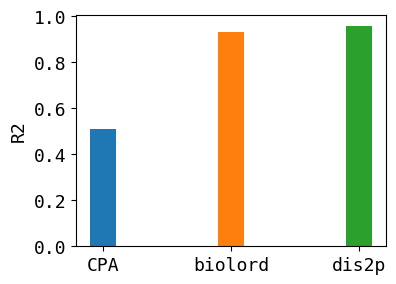

In [63]:
# plt.set_figwidth(2)
# plt.set_figheight(4)

plt.bar([1], [r2_log], width=0.1, label='CPA')
plt.bar([1.5], [r2_log_bio], width=0.1, label='biolord')
plt.bar([2], [r2_log_dis2p], width=0.1, label='dis2p')

plt.rcParams['figure.figsize'] = [4,4]

# c = [1, 3, 2, 1]

# plt.errorbar(a, b, yerr=c, fmt="o", color="r")

plt.ylabel('R2')

plt.xticks([1,1.5,2], ['CPA', 'biolord', 'dis2p'])
# plt.legend()
plt.show()

In [74]:
true_x_counts_mean_log = np.log1p(true_x_counts_mean)

outliers = 0
for i, _ in enumerate(x_pred_dis2p):
    if x_pred_dis2p[i] > 10:
        outliers = i
        print(i)
    


751


751

In [84]:
i = outliers
plt.scatter(x=torch.cat([true_x_counts_mean_log[:i], true_x_counts_mean_log[i+1:]]), 
            y=torch.cat([x_pred_dis2p[:i], x_pred_dis2p[i+1:]]))

plt.xlabel("True X")
plt.ylabel("Predicted X")

plt.show()

pandas.core.series.Series

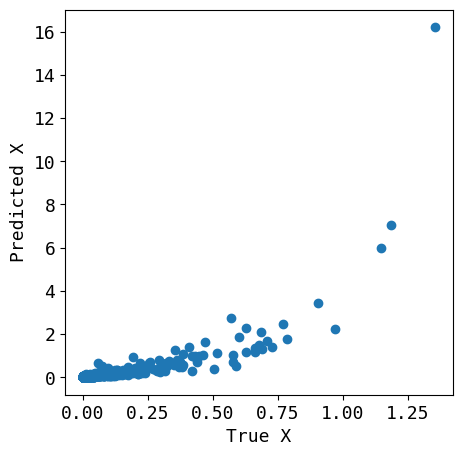

In [122]:
true_x_counts_mean_log = np.log1p(true_x_counts_mean_log)
plt.scatter(x=true_x_counts_mean_log, 
            y=x_pred_dis2p)

plt.xlabel("True X")
plt.ylabel("Predicted X")

plt.show()

In [149]:
n_top_deg = 100
adata.var['name'] = adata.var.index
sc.tl.rank_genes_groups(adata, cov_name, method='wilcoxon', key_added="wilcoxon")
ranked_genes = sc.get.rank_genes_groups_df(adata, group=cov_value_cf, key='wilcoxon', gene_symbols='name')
ranked_genes_names = ranked_genes[ranked_genes['name'].notnull()]['name']
deg_names = ranked_genes_names[:n_top_deg]
deg_idx = [i for i, _ in enumerate(adata.var['name']) if adata.var['name'][i] in list(deg_names)]

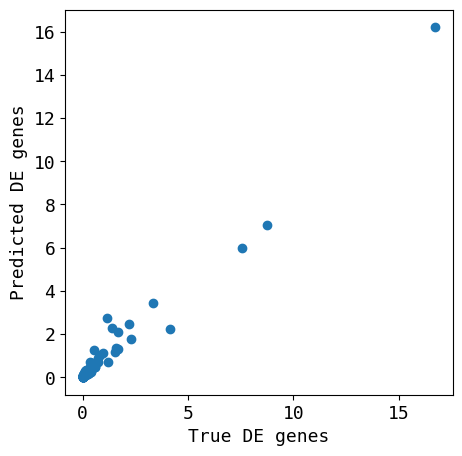

In [136]:
true_x_counts_mean_log = np.log1p(true_x_counts_mean)
x_pred_dis2p_log = np.log1p(x_pred_dis2p)

plt.scatter(x=true_x_counts_mean[deg_idx], 
            y=x_pred_dis2p[deg_idx])

plt.xlabel("True DE genes")
plt.ylabel("Predicted DE genes")

plt.show()

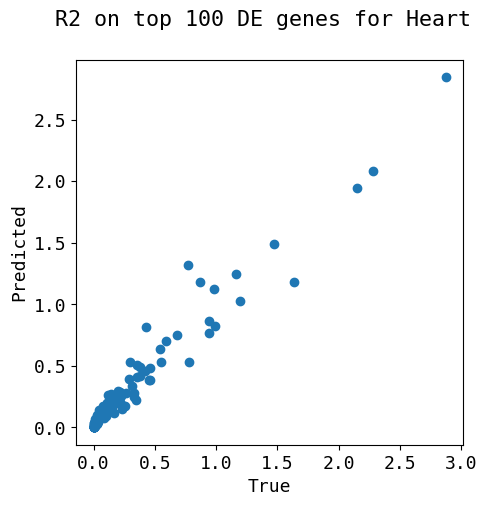

In [151]:
plt.scatter(x=true_x_counts_mean_log[deg_idx], 
            y=x_pred_dis2p_log[deg_idx])

plt.suptitle('R2 on top 100 DE genes for Heart')

plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('metrics/R2_deg_heart.png', dpi=300)

plt.show()

In [153]:
from sklearn.metrics import r2_score

r2_score(true_x_counts_mean_log[deg_idx], x_pred_dis2p_log[deg_idx])


0.9472850156632331

# final plot

In [147]:


r2_df_H = pd.read_csv('metrics/r2_save_HeartAtlas/r2.csv')
r2_log_cpa_H, r2_log_bio_H, r2_log_dis2p_H = r2_df_H.iloc[0, 1], r2_df_H.iloc[1, 1], r2_df_H.iloc[2, 1]

r2_df_L = pd.read_csv('metrics/r2_save_Herpes/r2.csv')
r2_log_cpa_L, r2_log_bio_L, r2_log_dis2p_L = r2_df_L.iloc[0, 1], r2_df_L.iloc[1, 1], r2_df_L.iloc[2, 1]

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i], float(f'{y[i]:.2f}') + 0.007, float(f'{y[i]:.2f}'), ha = 'center')
        


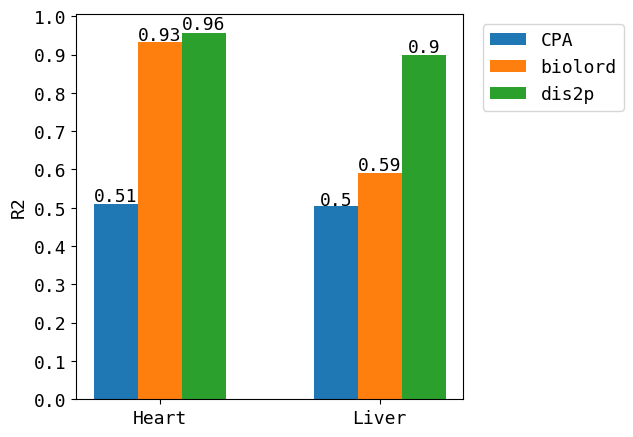

In [148]:
x1, x2 = 1, 1.5

plt.bar([x1, x2], [r2_log_cpa_H, r2_log_cpa_L], width=width, label='CPA')

addlabels([x1, x2], [r2_log_cpa_H, r2_log_cpa_L])

plt.bar([x1+width, x2+width], [r2_log_bio_H, r2_log_bio_L], width=width, label='biolord')

addlabels([x1+width, x2+width], [r2_log_bio_H, r2_log_bio_L])

plt.bar([x1+width*2, x2+width*2], [r2_log_dis2p_H, r2_log_dis2p_L], width=width, label='dis2p')

addlabels([x1+width*2, x2+width*2], [r2_log_dis2p_H, r2_log_dis2p_L])

# plt.rcParams['figure.figsize'] = [5,5]

plt.ylabel('R2')

plt.xticks([x1+width, x2+width], ['Heart', 'Liver'])

plt.yticks([i/10 for i in range(11)])

plt.legend(loc=(1.05, 0.75))


plt.savefig('metrics/R2_all.png', dpi=300)

plt.show()

In [144]:
r2_df_H = pd.read_csv('metrics/r2_save_HeartAtlas/r2_deg.csv')
r2_log_cpa_H, r2_log_bio_H, r2_log_dis2p_H = r2_df_H.iloc[0, 1], r2_df_H.iloc[1, 1], r2_df_H.iloc[2, 1]

r2_df_L = pd.read_csv('metrics/r2_save_Herpes/r2_deg.csv')
r2_log_cpa_L, r2_log_bio_L, r2_log_dis2p_L = r2_df_L.iloc[0, 1], r2_df_L.iloc[1, 1], r2_df_L.iloc[2, 1]

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i], float(f'{y[i]:.2f}') + 0.007, float(f'{y[i]:.2f}'), ha = 'center')
        


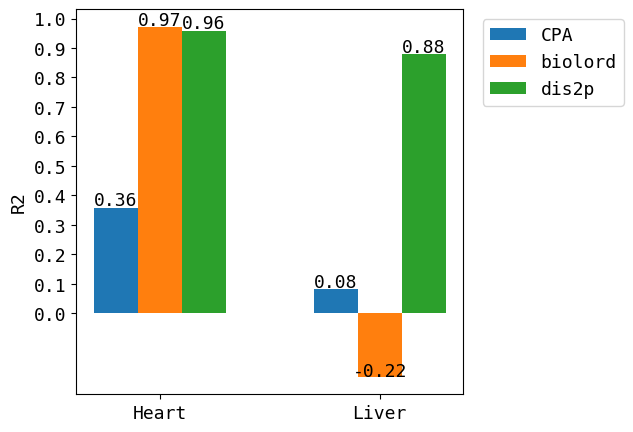

In [145]:
x1, x2 = 1, 1.5

plt.bar([x1, x2], [r2_log_cpa_H, r2_log_cpa_L], width=width, label='CPA')

addlabels([x1, x2], [r2_log_cpa_H, r2_log_cpa_L])

plt.bar([x1+width, x2+width], [r2_log_bio_H, r2_log_bio_L], width=width, label='biolord')

addlabels([x1+width, x2+width], [r2_log_bio_H, r2_log_bio_L])

plt.bar([x1+width*2, x2+width*2], [r2_log_dis2p_H, r2_log_dis2p_L], width=width, label='dis2p')

addlabels([x1+width*2, x2+width*2], [r2_log_dis2p_H, r2_log_dis2p_L])

# plt.rcParams['figure.figsize'] = [5,5]

plt.ylabel('R2')

plt.xticks([x1+width, x2+width], ['Heart', 'Liver'])

plt.yticks([i/10 for i in range(11)])

plt.legend(loc=(1.05, 0.75))

plt.savefig('')

plt.show()

In [120]:
width = 0.1
x1, x2, x3 = 1, 1.3, 1.6
x = [x1, x2, x3]


def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i], float(f'{y[i]:.2f}') + 0.007, float(f'{y[i]:.2f}'), ha = 'center')
        

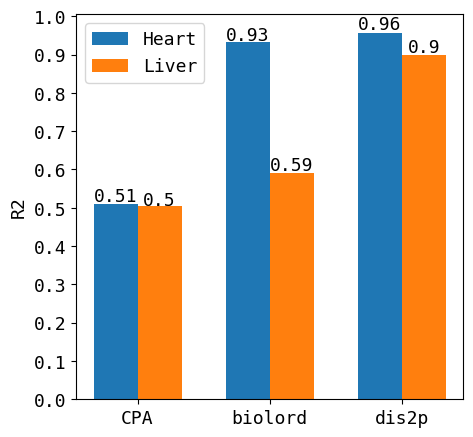

In [121]:

plt.bar([x1, x2, x3], [r2_log_cpa_H, r2_log_bio_H, r2_log_dis2p_H], width=width, label='Heart')

addlabels([x1, x2, x3], [r2_log_cpa_H, r2_log_bio_H, r2_log_dis2p_H])

plt.bar([x1+width, x2+width, x3+width], [r2_log_cpa_L, r2_log_bio_L, r2_log_dis2p_L], width=width, label='Liver')

addlabels([x1+width, x2+width, x3+width], [r2_log_cpa_L, r2_log_bio_L, r2_log_dis2p_L])

# plt.rcParams['figure.figsize'] = [5,5]

plt.ylabel('R2')

plt.xticks([x1+width/2, x2+width/2, x3+width/2], ['CPA', 'biolord', 'dis2p'])

plt.yticks([i/10 for i in range(11)])

plt.legend()

plt.show()